In [21]:
from function_utils import initialize_gee
initialize_gee('ee-nunezrimedio-tesina')

In [22]:
import ee
import h3
import pandas as pd
import geopandas as gpd
import numpy as np

def get_h3_polygon_ee(h3_address):
    """Convert H3 address to EE Geometry"""
    coords = h3.cell_to_boundary(h3_address)
    coords_ee = [[lon, lat] for lat, lon in coords]
    return ee.Geometry.Polygon([coords_ee])

# Clases
esa_classes = {
    10: "Trees",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Barren/sparse vegetation",
    70: "Snow and ice",
    80: "Water bodies",
    90: "Herbaceous wetland",
    95: "Mangroves",
    100: "Moss and lichen"
}

dw_classes = {
    0: "Water",
    1: "Trees",
    2: "Grass",
    3: "Flooded vegetation",
    4: "Crops",
    5: "Shrub and scrub",
    6: "Built",
    7: "Bare ground",
    8: "Snow and ice"
}

# Class mapping
class_mapping = {
    10: 1,    # Tree cover -> Trees
    20: 5,    # Shrubland -> Shrub & scrub
    30: 2,    # Grassland -> Grass
    40: 4,    # Cropland -> Crops
    50: 6,    # Built-up -> Built
    60: 7,    # Bare/sparse -> Bare
    70: 8,    # Snow and ice -> Snow & ice
    80: 0,    # Water bodies -> Water
    90: 3,    # Herbaceous wetland -> Flooded vegetation
    95: 3,    # Mangroves -> Flooded vegetation
    100: 7    # Moss and lichen -> Bare
}

def calculate_overall_metrics(esa_dict, dw_dict):
    """
    Calcula métricas de coincidencia entre clasificaciones ESA y Dynamic World
    considerando la agrupación correcta de clases
    """
    # Convierto strings a ints en los diccionarios de entrada
    esa_dict = {int(k): int(v) for k, v in esa_dict.items()}
    dw_dict = {int(k): int(v) for k, v in dw_dict.items()}

    # Agrupo las clases de ESA según la correspondencia con DW
    grouped_esa = {dw_class: 0 for dw_class in range(9)}  # Inicializo con todas las clases DW
    for esa_class, count in esa_dict.items():
        dw_class = class_mapping[esa_class]  # Uso el mapping correcto
        grouped_esa[dw_class] += count

    # Total de píxeles en cada dataset (después del agrupamiento para ESA)
    total_esa = sum(grouped_esa.values())
    total_dw = sum(dw_dict.values())

    # Calculo píxeles coincidentes usando las clases agrupadas
    matched_pixels_by_class = {}
    total_matched = 0
    for dw_class in grouped_esa.keys():
        esa_count = grouped_esa.get(dw_class, 0)
        dw_count = dw_dict.get(dw_class, 0)
        matched = min(esa_count, dw_count)
        matched_pixels_by_class[dw_class] = matched
        total_matched += matched

    # Métricas globales
    overall_precision = total_matched / total_dw if total_dw > 0 else 0
    overall_recall = total_matched / total_esa if total_esa > 0 else 0
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0
    overall_accuracy = total_matched / ((total_esa + total_dw)/2) if (total_esa + total_dw) > 0 else 0

    return {
        'overall_accuracy': overall_accuracy,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'total_esa_pixels': total_esa,
        'total_dw_pixels': total_dw,
        'matched_pixels': total_matched,
        'matched_pixels_by_class': matched_pixels_by_class,
        'grouped_esa': grouped_esa
    }

def analyze_landcover_h3(h3_address, year):
    """Analyze land cover proportions within an H3 hexagon"""

    # Get hexagon geometry
    hex_geom = get_h3_polygon_ee(h3_address)
    if year== 2020:
        # Load and clip ESA
        esa = ee.ImageCollection("ESA/WorldCover/v100").first().clip(hex_geom)
    if year == 2021:
        esa = ee.ImageCollection("ESA/WorldCover/v200").first().clip(hex_geom)
    # Load and clip DW
    
    dw = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1") \
        .filterDate(f'{year}-01-01', f'{year + 1}-01-01') \
        .select('label') \
        .mode() \
        .clip(hex_geom)

    # Calculate frequency histograms
    esa_counts = esa.reduceRegion( 
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=hex_geom,
        scale=10,
        bestEffort=True
    ).getInfo()

    dw_counts = dw.reduceRegion(       ## Modifiqué dw por dw_label
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=hex_geom,
        scale=10,
        bestEffort=True
    ).getInfo()

    # Extract counts
    esa_dict = esa_counts.get('Map', {})
    dw_dict = dw_counts.get('label', {})

    # Calculate overall metrics for hexagon
    overall_metrics = calculate_overall_metrics(esa_dict, dw_dict)

    # Get grouped ESA counts by DW class
    grouped_esa = overall_metrics['grouped_esa']
    matched_pixels_by_class = overall_metrics['matched_pixels_by_class']

    results = []
    total_all_pixels = 0

    for dw_class in range(9):  # For each DW class
        esa_pixels = grouped_esa.get(dw_class, 0)
        dw_pixels = int(dw_dict.get(str(dw_class), 0))
        total_pixels = esa_pixels + dw_pixels
        total_all_pixels += total_pixels

        # Calculate class-specific metrics
        matched = matched_pixels_by_class.get(dw_class, 0)
        precision = matched / dw_pixels if dw_pixels > 0 else 0
        recall = matched / esa_pixels if esa_pixels > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Calculate proportions
        esa_prop = esa_pixels / total_pixels if total_pixels > 0 else 0
        dw_prop = dw_pixels / total_pixels if total_pixels > 0 else 0

        results.append({
            'h3_address': h3_address,
            'dw_class': dw_class,
            'dw_class_name': dw_classes[dw_class],
            'esa_pixels': esa_pixels,
            'dw_pixels': dw_pixels,
            'total_pixels': total_pixels,
            'esa_proportion': esa_prop,
            'dw_proportion': dw_prop,
            'proportion_difference': abs(esa_prop - dw_prop),
            'correspondence': 'strong' if abs(esa_prop - dw_prop) <= 0.2 else 'weak',
            'matched_pixels': matched,
            'class_precision': precision,
            'class_recall': recall,
            'class_f1': f1_score,
            'hexagon_overall_accuracy': overall_metrics['overall_accuracy'],
            'hexagon_overall_precision': overall_metrics['overall_precision'],
            'hexagon_overall_recall': overall_metrics['overall_recall'],
            'hexagon_overall_f1': overall_metrics['overall_f1'],
            'hexagon_total_esa': overall_metrics['total_esa_pixels'],
            'hexagon_total_dw': overall_metrics['total_dw_pixels'],
            'hexagon_matched_pixels': overall_metrics['matched_pixels']
        })

    # Create DataFrame
    df = pd.DataFrame(results)

    # Calculate overall metrics for classes
    overall_class_row = pd.DataFrame([{
        'h3_address': h3_address,
        'dw_class': 'Overall',
        'dw_class_name': 'Overall',
        'esa_pixels': df['esa_pixels'].sum(),
        'dw_pixels': df['dw_pixels'].sum(),
        'total_pixels': total_all_pixels,
        'esa_proportion': 1.0,
        'dw_proportion': 1.0,
        'proportion_difference': np.nan,
        'correspondence': 'NA',
        'matched_pixels': overall_metrics['matched_pixels'],
        'class_precision': df['class_precision'].mean(),
        'class_recall': df['class_recall'].mean(),
        'class_f1': df['class_f1'].mean(),
        'hexagon_overall_accuracy': overall_metrics['overall_accuracy'],
        'hexagon_overall_precision': overall_metrics['overall_precision'],
        'hexagon_overall_recall': overall_metrics['overall_recall'],
        'hexagon_overall_f1': overall_metrics['overall_f1'],
        'hexagon_total_esa': overall_metrics['total_esa_pixels'],
        'hexagon_total_dw': overall_metrics['total_dw_pixels'],
        'hexagon_matched_pixels': overall_metrics['matched_pixels']
    }])

    return pd.concat([df, overall_class_row], ignore_index=True)

# Run analysis
#h3_address = '83cea2fffffffff'
#year = 2020
#results_df = analyze_landcover_h3(h3_address, year)
#results_df

In [23]:
from tqdm import tqdm
import numpy as np

def analyze_multiple_h3(h3_addresses, year):
    """
    Analyze land cover proportions for multiple H3 hexagons
    
    Parameters:
    -----------
    h3_addresses : list
        List of H3 addresses to analyze
    year : int
        Year to analyze
    
    Returns:
    --------
    pandas.DataFrame
        Concatenated results for all hexagons, including failed ones with NAs
    """
    # Initialize empty list to store results
    all_results = []

    # Get all column names from a successful run to use as template
    try:
        template_df = analyze_landcover_h3(h3_addresses[0], year)
        columns = template_df.columns
    except Exception as e:
        print(f"Error getting template from first hexagon: {str(e)}")
        return pd.DataFrame()

    # Process each hexagon with progress bar
    for h3_address in tqdm(h3_addresses, desc="Processing hexagons"):
        try:
            # Get results for this hexagon
            hexagon_results = analyze_landcover_h3(h3_address, year)
            all_results.append(hexagon_results)
        except Exception as e:
            print(f"\nError processing hexagon {h3_address}: {str(e)}")
            # Create error row with NAs
            error_df = pd.DataFrame({
                'h3_address': [h3_address],
                'esa_class': ['Error'],
                'dw_class': ['Error'],
                'esa_class_name': ['Error'],
                'dw_class_name': ['Error']
            })
            # Fill remaining columns with NA
            for col in columns:
                if col not in error_df.columns:
                    error_df[col] = np.nan

            all_results.append(error_df)
            continue

    # Concatenate all results
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()  # Return empty DataFrame if no results

In [24]:
gdf = gpd.read_file("/Users/santi/DataspellProjects/Tesina/Scripts/Data/Geo/Hexagonos_H3_Argentina_Resolution_4.geojson")
gdf.head()

,index,geometry
0,84cfa2bffffffff,"POLYGON ((-68.93974 -50.54134, -68.74315 -50.3..."
1,84cea07ffffffff,"POLYGON ((-71.26975 -43.36204, -71.08761 -43.1..."
2,84b34e1ffffffff,"POLYGON ((-62.72670 -24.35562, -62.91615 -24.5..."
3,84b34a1ffffffff,"POLYGON ((-62.78079 -25.39658, -62.97111 -25.5..."
4,84c36c5ffffffff,"POLYGON ((-67.17063 -35.74978, -67.38116 -35.8..."


In [25]:
# Usage example:
h3_addresses = gdf["index"].to_list()
year = 2020
results_df = analyze_multiple_h3(h3_addresses, year)

Processing hexagons:   3%|▎         | 53/1921 [39:46<14:58:43, 28.87s/it]


Error processing hexagon 84c328dffffffff: User memory limit exceeded.


Processing hexagons:   5%|▍         | 89/1921 [4:59:00<102:34:48, 201.58s/it]


KeyboardInterrupt: 

In [15]:
results_df.head()

""


In [16]:
results_df.to_csv("/Users/santi/DataspellProjects/Tesina/Scripts/Data/Geo/DW_Validado_Resolution_4.csv")

KeyError: 'h3_address'

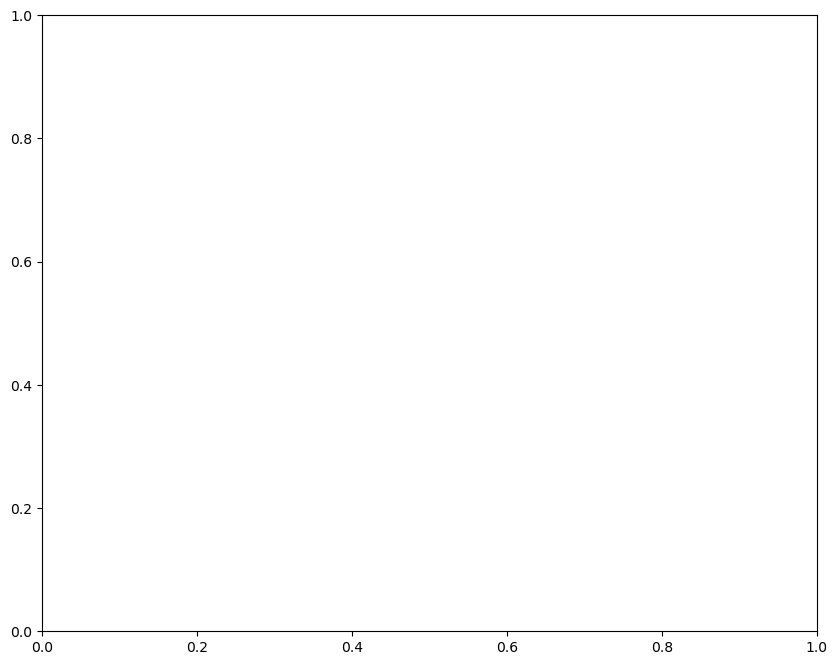

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
merged = gdf.merge(results_df, left_on="index", right_on="h3_address")
merged.plot(
    column="hexagon_overall_accuracy",
    ax=ax,
    legend=True,
    cmap='viridis',  # or any other colormap like 'viridis', 'YlOrRd', etc.
    legend_kwds={'label': 'Overall Accuracy'}
)
plt.title('Spatial Distribution of Classification Accuracy')
plt.axis('equal')
plt.show()